## Imports

In [ ]:
import os
import sys
sys.path.append('/home/sardarchitect/repos/github.com/ucsd_capstone/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatch
import seaborn as sns
import torch
import cv2 as cv
import scipy.optimize
from tqdm import tqdm

from streetstudy.data import virat
from streetstudy.common import display
from streetstudy.model import yolo
from streetstudy.common import evaluation


## Load Data

In [2]:
# Get video data
video_df = virat.get_dataset_df()
video_df.head()

,path,num_frames,duration,image_width,image_height,event_file,object_file,mapping_file
name,,,,,,,,
VIRAT_S_010200_08_000838_000867,/home/sardarchitect/repos/github.com/ucsd_caps...,532,22,1280.0,720.0,VIRAT_S_010200_08_000838_000867.viratdata.even...,VIRAT_S_010200_08_000838_000867.viratdata.obje...,VIRAT_S_010200_08_000838_000867.viratdata.mapp...
VIRAT_S_000200_03_000657_000899,/home/sardarchitect/repos/github.com/ucsd_caps...,7243,241,1280.0,720.0,VIRAT_S_000200_03_000657_000899.viratdata.even...,VIRAT_S_000200_03_000657_000899.viratdata.obje...,VIRAT_S_000200_03_000657_000899.viratdata.mapp...
VIRAT_S_050000_08_001235_001295,/home/sardarchitect/repos/github.com/ucsd_caps...,1792,59,1920.0,1080.0,VIRAT_S_050000_08_001235_001295.viratdata.even...,VIRAT_S_050000_08_001235_001295.viratdata.obje...,VIRAT_S_050000_08_001235_001295.viratdata.mapp...
VIRAT_S_050000_06_000908_000970,/home/sardarchitect/repos/github.com/ucsd_caps...,1855,61,1920.0,1080.0,VIRAT_S_050000_06_000908_000970.viratdata.even...,VIRAT_S_050000_06_000908_000970.viratdata.obje...,VIRAT_S_050000_06_000908_000970.viratdata.mapp...
VIRAT_S_010208_08_000807_000831,/home/sardarchitect/repos/github.com/ucsd_caps...,420,17,1280.0,720.0,VIRAT_S_050000_06_000908_000970.viratdata.even...,VIRAT_S_010208_08_000807_000831.viratdata.obje...,VIRAT_S_050000_06_000908_000970.viratdata.mapp...


In [3]:
# Select a video
current_video = video_df.loc['VIRAT_S_010203_08_000895_000975']

In [4]:
# Get annotations from selected video (VIRAT format)
annotations_df = virat.get_annotations_df(current_video["path"])
annotations_df.head()

,object_id,object_duration,current_frame,bbox_lefttop_x,bbox_lefttop_y,bbox_width,bbox_height,object_type
493,2,457,1200,126,227,19,37,1
494,2,457,1201,126,227,19,37,1
495,2,457,1202,126,227,19,37,1
496,2,457,1203,126,227,19,37,1
497,2,457,1204,126,227,19,37,1


In [5]:
# Get annotations from selected video (YOLO format)
annotations_df = virat.get_annotations_df(current_video["path"], format='yolo', normalize=False, object_id=True)
annotations_df.head()

,current_frame,object_id,object_type,bbox_center_x,bbox_center_y,bbox_width,bbox_height
493,1200,2,0,135.5,245.5,19,37
494,1201,2,0,135.5,245.5,19,37
495,1202,2,0,135.5,245.5,19,37
496,1203,2,0,135.5,245.5,19,37
497,1204,2,0,135.5,245.5,19,37


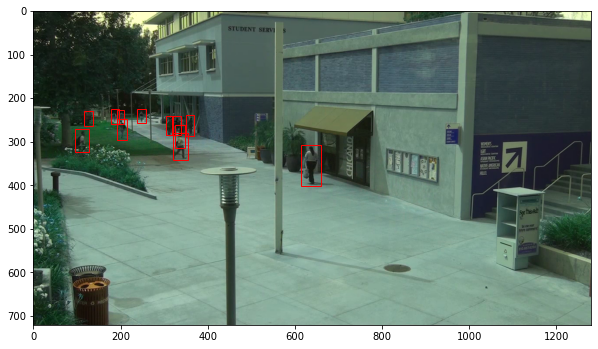

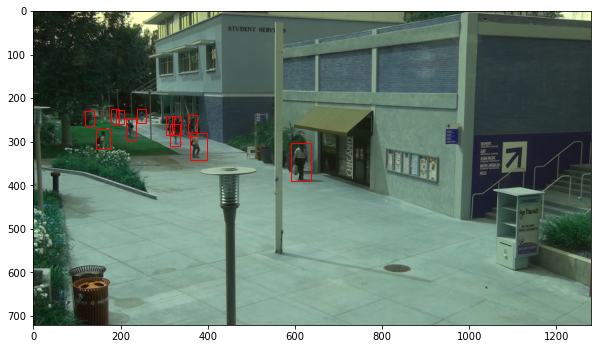

In [6]:
# View data to see some annotated frames
display.display_annotated_frame(current_video["path"], annotations_df, 180)
display.display_annotated_frame(current_video["path"], annotations_df, 200)

## Load Pretrained Model

In [7]:
model = yolo.yolov5()

Using cache found in /home/sardarchitect/.cache/torch/hub/ultralytics_yolov5_master


requirements: /home/sardarchitect/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5 🚀 2023-4-30 Python-3.11.3 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [8]:
preds = yolo.predict_video(model, current_video['path'], is_df=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1871/1871 [00:34<00:00, 54.95it/s]


In [9]:
preds.head()

,current_frame,bbox_center_x,bbox_center_y,bbox_width,bbox_height,conf,class
0,0.0,900.471375,456.619659,53.932739,138.565491,0.824924,0.0
1,0.0,417.088440,305.284790,20.376831,53.775330,0.589938,0.0
2,1.0,897.292908,452.589294,51.109619,136.385651,0.816812,0.0
3,1.0,416.741119,305.109070,20.155029,53.096436,0.594558,0.0
4,2.0,897.347778,452.563354,51.113525,136.503052,0.817343,0.0


In [10]:
annotations_df.sort_values('current_frame', inplace=True)
annotations_df.head()

,current_frame,object_id,object_type,bbox_center_x,bbox_center_y,bbox_width,bbox_height
3124,0,6,0,181.0,241.0,22,32
4668,0,9,0,202.0,246.0,18,34
4371,0,8,0,213.0,245.0,18,32
18642,0,38,0,322.0,251.0,20,48
15962,0,31,0,897.5,454.0,61,144


In [11]:
total_precision = []
total_recall = []
for current_frame in range(current_video['num_frames']):
    bbox_pred = preds[preds['current_frame'] == current_frame]
    bbox_gt = annotations_df[annotations_df['current_frame'] == current_frame]
    
    bbox_gt_match, bbox_pred_match, bbox_pred_ious, bbox_pred_labels = evaluation.match_bboxes(bbox_gt, bbox_pred)
    precision, recall = evaluation.precision_recall(bbox_gt, bbox_pred, bbox_pred_labels)
    total_precision.append(precision)
    total_recall.append(recall)

In [12]:
average_precision = sum(total_precision) / len(total_precision)
average_recall = sum(total_recall) / len(total_recall)

print(average_precision)
print(average_recall)

0.888826475798683
0.6254660803297964


## Organize Directories

In [13]:
# See 20230512_YOLO Format Conversion.ipynb to see code for converting VIRAT data directories to YOLO format

## Train

In [14]:
!python ../yolov5/train.py --img 640 --batch 16 --epochs 3 --data ../scripts/dataset.yaml --cfg ../scripts/yolov5s.yaml --weights yolov5s.pt --name streetstudy --cache

train: weights=yolov5s.pt, cfg=../scripts/yolov5s.yaml, data=../scripts/dataset.yaml, hyp=../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../yolov5/runs/train, name=streetstudy, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 4 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5 🚀 v7.0-168-gec2b853 Python-3.11.3 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bia

## Test

## Postprocessing